## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

## MNIST Dataset

In [2]:
from sklearn.datasets import fetch_openml
mnist= fetch_openml('mnist_784', version=1)

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

## Data Processing and Augmentation

In [6]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape(28, 28)
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [7]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [image for image in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)
        
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [8]:
from sklearn.preprocessing import OneHotEncoder
oneHot = OneHotEncoder()
y_train_augmented = oneHot.fit_transform(np.reshape(y_train_augmented, (-1, 1)))
y_test = oneHot.fit_transform(np.reshape(y_test, (-1, 1)))

C:\Users\Brenno Ribeiro\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\Brenno Ribeiro\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour a

In [9]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train = X_train_augmented[shuffle_idx]
y_train = y_train_augmented[shuffle_idx]

In [10]:
X_train, X_test = np.reshape(X_train, (X_train.shape[0], 28, 28, 1)), np.reshape(X_test, (X_test.shape[0], 28, 28, 1))

In [11]:
X_train, X_test = X_train / 255, X_test / 255

## Convolutional Neural Network

In [12]:
import tensorflow as tf
from tensorflow._api.v1.keras.models import Sequential
from tensorflow._api.v1.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow._api.v1.keras.layers import BatchNormalization

In [13]:
model = Sequential()

In [14]:
model.add(Conv2D(filters=48, input_shape=(28, 28, 1), kernel_size=(2, 2), strides=(1, 1), padding='SAME', activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding='VALID'))
model.add(Conv2D(filters=96, kernel_size=(3, 3), strides=(1, 1), padding='SAME'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2, padding='VALID'))
model.add(Flatten())

model.add(Dense(1024, input_shape=(28*28,), activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 48)        240       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 96)        41568     
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 96)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4704)              0         
__________

In [15]:
history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=30)

Train on 297500 samples, validate on 10500 samples
Epoch 1/30
297500/297500 [==============================] - 75s 251us/step - loss: 0.0940 - acc: 0.9727 - val_loss: 0.0353 - val_acc: 0.9894
Epoch 2/30
297500/297500 [==============================] - 72s 242us/step - loss: 0.0442 - acc: 0.9879 - val_loss: 0.0348 - val_acc: 0.9901
Epoch 3/30
297500/297500 [==============================] - 72s 242us/step - loss: 0.0355 - acc: 0.9906 - val_loss: 0.0663 - val_acc: 0.9865
Epoch 4/30
297500/297500 [==============================] - 72s 242us/step - loss: 0.0323 - acc: 0.9920 - val_loss: 0.0408 - val_acc: 0.9927
Epoch 5/30
297500/297500 [==============================] - 72s 242us/step - loss: 0.0297 - acc: 0.9927 - val_loss: 0.0405 - val_acc: 0.9926
Epoch 6/30
297500/297500 [==============================] - 72s 242us/step - loss: 0.0276 - acc: 0.9936 - val_loss: 0.0530 - val_acc: 0.9877
Epoch 7/30
297500/297500 [==============================] - 72s 242us/step - loss: 0.0255 - acc: 0.9942

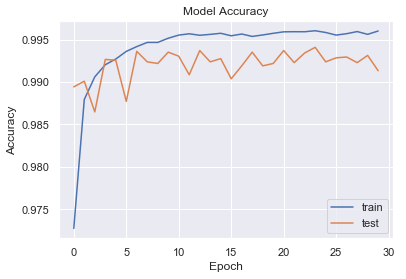

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.show()

In [17]:
history.history['val_acc']

[0.9894285714285714,
 0.9900952380952381,
 0.9864761904761905,
 0.9926666666666667,
 0.9925714285714285,
 0.9877142857142858,
 0.9936190476190476,
 0.9923809523809524,
 0.9921904761904762,
 0.9935238095238095,
 0.9930476190476191,
 0.9908571428571429,
 0.9937142857142857,
 0.9923809523809524,
 0.9927619047619047,
 0.9903809523809524,
 0.991904761904762,
 0.9935238095238095,
 0.991904761904762,
 0.9921904761904762,
 0.9937142857142857,
 0.9922857142857143,
 0.9934285714285714,
 0.9940952380952381,
 0.9923809523809524,
 0.9928571428571429,
 0.9929523809523809,
 0.9922857142857143,
 0.9931428571428571,
 0.9913333333333333]